## Zadanie 1 - Dla obrazu monochromatycznego:
1. Obliczyć entropię obrazu wejściowego.
1. Wyznaczyć obraz różnicowy w taki sposób, że wartość każdego piksela zastępowana jest różnicą
pomiędzy wartością tego piksela a wartością jego lewego sąsiada (kodowanie różnicowe /.
predykcyjne). Dla pierwszego piksela w linii należy przyjąć wartość sąsiada równą 127 (środkowa
wartość przedziału zmienności wartości pikseli).\
Wyświetlić obraz różnicowy.\
Wyznaczyć histogram obrazu różnicowego i porównać go z histogramem obrazu oryginalnego.\
Wyznaczyć entropię obrazu różnicowego i porównać ją z entropią obrazu oryginalnego.\
Uwaga: należy pamiętać, że wartości pikseli w obrazie różnicowym są z zakresu [-255; 255]!
1. Wyznaczyć współczynniki DWT korzystając z funkcji zamieszczonej w przykładowym skrypcie.\
Wyświetlić poszczególne pasma.\
Wyznaczyć histogramy i obliczyć entropię dla wszystkich pasm.\
Porównać wyniki (histogram, entropia) uzyskane dla poszczególnych pasm między sobą (czy któreś
się wyróżniają i dlaczego?) oraz z wynikami uzyskanymi dla obrazu oryginalnego i obrazu
różnicowego.
Uwaga: należy pamiętać, że wartości w pasmach LH, HL i HH są z zakresu [-255, 255]!\
1. Obliczyć przepływność (liczbę bitów przypadającą na jeden piksel) dla obrazu skompresowanego
koderem PNG (obraz wejściowy) i porównać ją z obliczonymi uprzednio entropiami obrazu
oryginalnego, różnicowego i falokowego.\
Czy przepływność mniejsza od entropii oznacza, że
zależność: lśr ≥ H jest nieprawdziwa?


In [101]:
# Import the necessary packages and initialize the list of reference
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

os.makedirs("results1", exist_ok=True)
os.makedirs("results2", exist_ok=True)

image_mono = cv2.imread("images/sailboats_mono.png", cv2.IMREAD_UNCHANGED)
image_color = cv2.imread("images/sailboats_col.png", cv2.IMREAD_UNCHANGED)

def printi(img, img_title="image"):
    print(f"{img_title}, wymiary: {img.shape}, typ danych: {img.dtype}, wartości: {img.min()} - {img.max()}")


def cv_imshow(img, img_title="image"):
    if (img.dtype == np.float32) or (img.dtype == np.float64):
        img_ = img / 255
    elif img.dtype == np.int16:
        img_ = img*128
    else:
        img_ = img
    cv2.imshow(img_title, img_)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### 1. Obliczanie entropii

In [102]:
def calc_entropy(hist):
    pdf = hist/hist.sum() # Histogram normalized to probability density function (PDF)
    entropy = -sum([x*np.log2(x) for x in pdf if x != 0])
    return entropy

hist_image = cv2.calcHist([image_mono], [0], None, [256], [0, 256]).flatten()

H_image = calc_entropy(hist_image)
print(f"H(image) = {H_image:.4f}")

H(image) = 7.0567


### 2.1. Wyznaczyć obraz różnicowy

In [103]:
img_tmp1 = image_mono[:, 1:]
img_tmp2 = image_mono[:, :-1]

image_hdiff = cv2.addWeighted(img_tmp1, 1, img_tmp2, -1, 0, dtype=cv2.CV_16S)

# Add first column
image_hdiff_0 = cv2.addWeighted(image_mono[:, 0], 1, 0, 0, -127, dtype=cv2.CV_16S)
image_hdiff = np.hstack((image_hdiff_0, image_hdiff))

### 2.2. Wyświetlić obraz różnicowy

In [104]:
cv_imshow(image_hdiff, "image_hdiff")
image_scaled = (np.clip((image_hdiff + 255), 0, 510) * 0.5).astype(np.uint8)
cv2.imwrite("results1/image_hdiff.png", image_scaled)

True

### 2.3 Histogram różnicowy i oryginalny

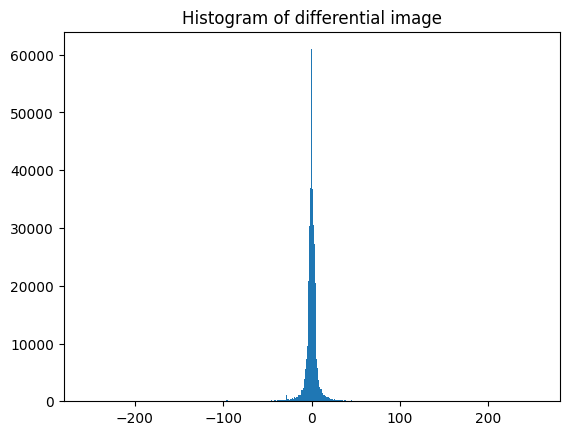

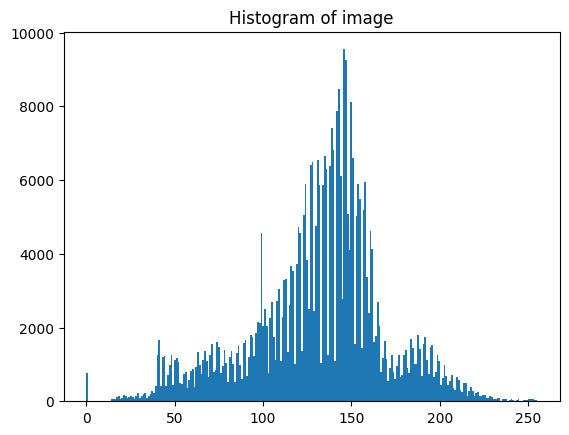

In [105]:
plt.figure()
plt.hist(image_hdiff.flatten(), 511, range=[-255.0, 255.0])
plt.title("Histogram of differential image")
plt.show()

plt.figure()
plt.hist(image_mono.flatten(), 256, range=[0.0, 255.0])
plt.title("Histogram of image")
plt.show()

Obraz różnicowy przedstawia różnicę wartości piksela względem jego sąsiada.\
Histogram różnicowy względem oryginalnego:\
Ma 2-razy większy zakres wartości [-255, 255]\
Wartości są bardziej skoncentrowane i zbliżone do zera.\

### 2.4. Entropia obrazu różnicowego i oryginalnego

In [106]:
# Calculate entropy of image_hdiff
image_tmp = (image_hdiff+255).astype(np.uint16)
hist_hdiff = cv2.calcHist([image_tmp], [0], None, [511], [0, 511]).flatten()

H_hdiff = calc_entropy(hist_hdiff)
print(f"H(hdiff) = {H_hdiff:.4f}")
print(f"H(image) = {H_image:.4f}")

H(hdiff) = 4.5567
H(image) = 7.0567


Entropia obrazu różnicowego jest mniejsza od obrazu oryginalnego, gdyż histogram obrazu różnicowanego jest bardziej skoncentrowany.

### 3.1-2. Wyznaczyć współczynniki DWT oraz wyświetlenie poszczególnych pasm

In [107]:
def dwt(img):
    maskL = np.array([0.02674875741080976, -0.01686411844287795, -0.07822326652898785, 0.2668641184428723,
        0.6029490182363579, 0.2668641184428723, -0.07822326652898785, -0.01686411844287795, 0.02674875741080976])
    maskH = np.array([0.09127176311424948, -0.05754352622849957, -0.5912717631142470, 1.115087052456994,
        -0.5912717631142470, -0.05754352622849957, 0.09127176311424948])

    bandLL = cv2.sepFilter2D(img,         -1, maskL, maskL)[::2, ::2]
    bandLH = cv2.sepFilter2D(img, cv2.CV_16S, maskL, maskH)[::2, ::2]  # Result is signed
    bandHL = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskL)[::2, ::2]
    bandHH = cv2.sepFilter2D(img, cv2.CV_16S, maskH, maskH)[::2, ::2]

    return bandLL, bandLH, bandHL, bandHH

In [108]:
# DWT coefficients
ll, lh, hl, hh = dwt(image_mono)
printi(ll, "LL")
printi(lh, "LH")
printi(hl, "HL")
printi(hh, "HH")

cv2.imwrite("results2/ll.png", ll)
lh_clipped = np.clip(lh, 0, 255)
cv2.imwrite("results2/lh.png", lh_clipped)
hl_clipped = np.clip(hl, 0, 255)
cv2.imwrite("results2/hl.png", hl_clipped)
hh_clipped = np.clip(hh, 0, 255)

cv2.imwrite("results2/hh.png", hh_clipped)

LL, wymiary: (384, 256), typ danych: uint8, wartości: 9 - 255
LH, wymiary: (384, 256), typ danych: int16, wartości: -97 - 125
HL, wymiary: (384, 256), typ danych: int16, wartości: -116 - 164
HH, wymiary: (384, 256), typ danych: int16, wartości: -110 - 152


True

### 3.3 Wyznaczyć histogramy oraz entropie dla wszystkich pasm

H(LL) = 7.1395 
H(LH) = 4.1734 
H(HL) = 4.0514 
H(HH) = 4.2601 
H_śr = 4.9061


(-255.0, 255.0)

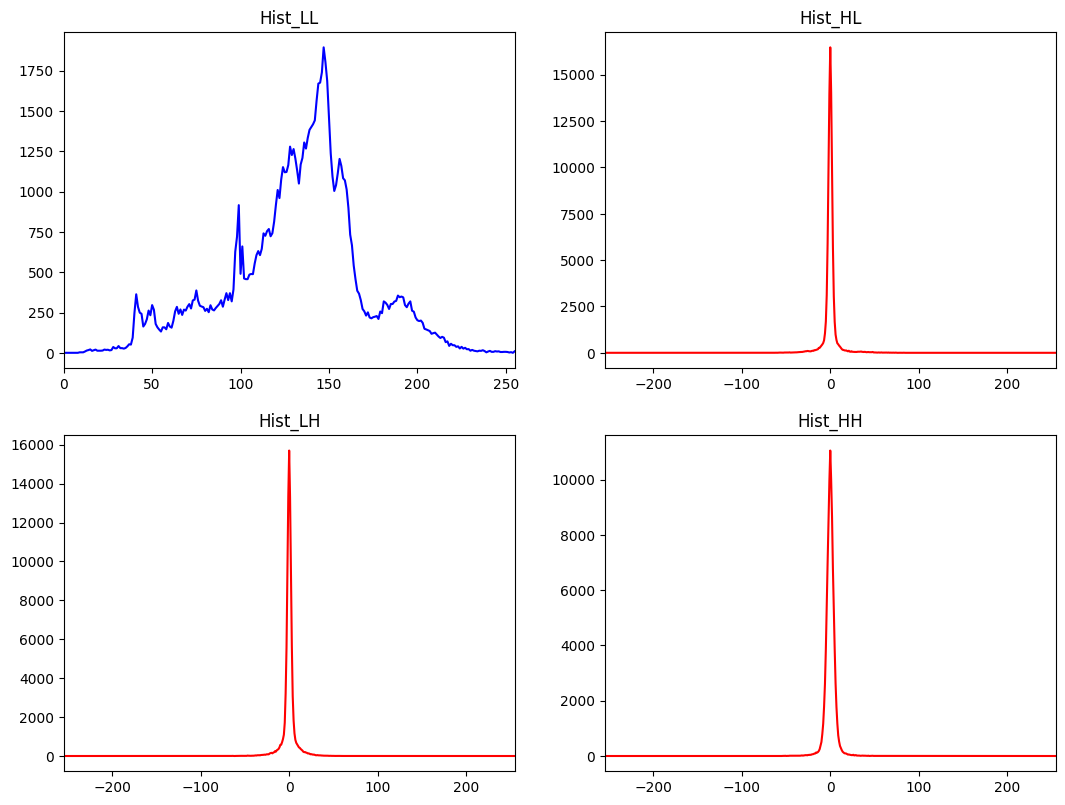

In [109]:
hist_ll = cv2.calcHist([ll], [0], None, [256], [0, 256]).flatten()
hist_lh = cv2.calcHist([(lh + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hl = cv2.calcHist([(hl + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()
hist_hh = cv2.calcHist([(hh + 255).astype(np.uint16)], [0], None, [511], [0, 511]).flatten()

H_ll = calc_entropy(hist_ll)
H_lh = calc_entropy(hist_lh)
H_hl = calc_entropy(hist_hl)
H_hh = calc_entropy(hist_hh)
print(f"H(LL) = {H_ll:.4f} \nH(LH) = {H_lh:.4f} \nH(HL) = {H_hl:.4f} \nH(HH) = {H_hh:.4f} \nH_śr = {(H_ll+H_lh+H_hl+H_hh)/4:.4f}")


fig = plt.figure()
fig.set_figheight(fig.get_figheight()*2)
fig.set_figwidth(fig.get_figwidth()*2)
plt.subplot(2, 2, 1)
plt.plot(hist_ll, color="blue")
plt.title("Hist_LL")
plt.xlim([0, 255])
plt.subplot(2, 2, 3)
plt.plot(np.arange(-255, 256, 1), hist_lh, color="red")
plt.title("Hist_LH")
plt.xlim([-255, 255])
plt.subplot(2, 2, 2)
plt.plot(np.arange(-255, 256, 1), hist_hl, color="red")
plt.title("Hist_HL")
plt.xlim([-255, 255])
plt.subplot(2, 2, 4)
plt.plot(np.arange(-255, 256, 1), hist_hh, color="red")
plt.title("Hist_HH")
plt.xlim([-255, 255])

### 3.4. Porównanie wyników

Pasma o wyższej częstotliwości HL, LH, HH mają mniejszą entropię niż pasmo niskich częstotliwości LL.\
Histogramy HL, LH, HH są bardziej skoncentrowane w pobliżu 0.\
Entropia oraz histogramy pasm HL, LH, HH są podobne do obrazu różnicowego. Natomiast pasmo LL do oryginalnego. Spowodowane jest to tym, że pasmo LL skupia się na głównych kształtach tak jak obraz oryginalny, a pozostałe pasma to szczegóły tak jak jest to w przyapdku obrazu różnicowego.

### 4.1. Obliczyć przepływność dla obrazu skompresowanego koderem PNG

In [110]:
bitrate = 8 * os.stat("images/sailboats_mono.png").st_size / (image_mono.shape[0] * image_mono.shape[1])
print(f"bitrate: {bitrate:.4f}")

bitrate: 4.6111


Bitrate jest mniejszy od entropii obrazu oryginalnego ale podobny do entropii obrazu różnicowego.\
W odniesieniu do entropii pasm falkowych jest on mniejszy od średniej entropii ale wyższy od entropii pasm wysokoczęstotliwościowych.\
Wniosek:\
Oznacza to, że algorytm PNG skutecznie wykorzystał zależności lokalne pomiędzy pikselami, osiągając niemal optymalną kompresję względem modelu różnicowego. Tym samym kompresja bezstratna zbliżyła się do teoretycznego limitu wynikającego z entropii różnicowej.\

Czy przepływność mniejsza od entropii oznacza, że zależność: lśr ≥ H jest nieprawdziwa?/
Entropia obliczonego obrazu dotyczy pojedynczych pikseli. Ignoruje zależności przestrzenne. Zakłada, że piksele są niezależne.\
Natomiast PNG to kompresja z predykcją. Uwzględnia zależności.\
Naszą zależność powinniśmy porównać do innego źródła. Do entropii obrazu różnicowego. Dla tego źródła zależność jest spełniona:\
lśr ≥ H(hdiff)\
4.6111 ≥ 4.5567


## Zadanie 2. Dla obrazu barwnego
1. Obliczyć entropię dla składowych RGB barwnego obrazu testowego.
1. Dokonać konwersji z RGB do YUV i obliczyć entropię dla składowych YUV.\
Wyświetlić składowe RGB i YUV.\
Wyznaczyć histogramy dla wszystkich składowych RGB i YUV.\
Porównać wyniki uzyskane dla poszczególnych składowych. Czy dla składowych UV entropia jest
mniejsza? Z czego ta mniejsza wartość może wynikać?
1. Wyznaczyć zależność zniekształcenia D od przepływności R (liczba bitów przypadającą na jeden
piksel obrazu): D = f(R) – tzw. krzywa R-D – dla kodera JPEG.\
Regulacji stopnia kompresji (przepływności R) należy dokonywać ustawiając wartości parametru
‘quality’ przy zapisie obrazu do pliku. Wartości parametru ‘quality’ należy dobrać tak, aby uzyskać
‘gładkie’ wykresy.\
Jako miarę zniekształceń należy użyć szczytowy stosunek sygnału do szumu PSNR i błąd
średniokwadratowy MSE.\
Zobrazować zależności na wykresach (oddzielny wykres dla każdej miary).\
Dokonać subiektywnej oceny obrazów zrekonstruowanych (według własnej skali ocen, np.: jakość
doskonała, bardzo dobra, dobra, średnia, kiepska, zła, bardzo zła, itp., lub: zniekształcenia
niewidoczne, lekko widoczne, widoczne, bardzo widoczne, nie do przyjęcia, itp.) i zamieścić te oceny
w sprawozdaniu (niekoniecznie dla każdego obrazu wynikowego osobno, raczej ‘zgrupować’ oceny
dla pewnych zakresów przepływności).\
Porównać stopnie kompresji uzyskiwane dla kodera JPEG ze stopniem kompresji uzyskanym dla
kodera PNG (pamiętając, że w pierwszej części laboratorium wykorzystywany był
monochromatyczny obraz PNG, a kompresja JPEG była wykonywana dla obrazu barwnego;
ewentualnie obliczyć przepływność bitową dla obrazu barwnego skompresowanego koderem PNG).

### Zad 1,2 Entropie i histogramy obrazu RGB i YUV

In [111]:
# RGB
image_R = image_color[:, :, 2]  # cv2 loads images in BGR format
image_G = image_color[:, :, 1]
image_B = image_color[:, :, 0]

hist_R = cv2.calcHist([image_R], [0], None, [256], [0, 256]).flatten()
hist_G = cv2.calcHist([image_G], [0], None, [256], [0, 256]).flatten()
hist_B = cv2.calcHist([image_B], [0], None, [256], [0, 256]).flatten()

H_R = calc_entropy(hist_R)
H_G = calc_entropy(hist_G)
H_B = calc_entropy(hist_B)
print(f"H(R) = {H_R:.4f} \nH(G) = {H_G:.4f} \nH(B) = {H_B:.4f} \nH_śr = {(H_R+H_G+H_B)/3:.4f}\n")

# YUV
image_YUV = cv2.cvtColor(image_color, cv2.COLOR_BGR2YUV) ### albo: cv2.COLOR_BGR2YUV

image_Y = image_YUV[:, :, 0]
image_U = image_YUV[:, :, 1]
image_V = image_YUV[:, :, 2]

hist_Y = cv2.calcHist([image_Y], [0], None, [256], [0, 256]).flatten()
hist_U = cv2.calcHist([image_U], [0], None, [256], [0, 256]).flatten()
hist_V = cv2.calcHist([image_V], [0], None, [256], [0, 256]).flatten()

H_Y = calc_entropy(hist_Y)
H_U = calc_entropy(hist_U)
H_V = calc_entropy(hist_V)
print(f"H(Y) = {H_Y:.4f} \nH(U) = {H_U:.4f} \nH(V) = {H_V:.4f} \nH_śr = {(H_Y+H_U+H_V)/3:.4f}")


H(R) = 7.1888 
H(G) = 7.2118 
H(B) = 6.9404 
H_śr = 7.1137

H(Y) = 7.0808 
H(U) = 4.2746 
H(V) = 3.9357 
H_śr = 5.0970


### Wyświetlenie histogramów

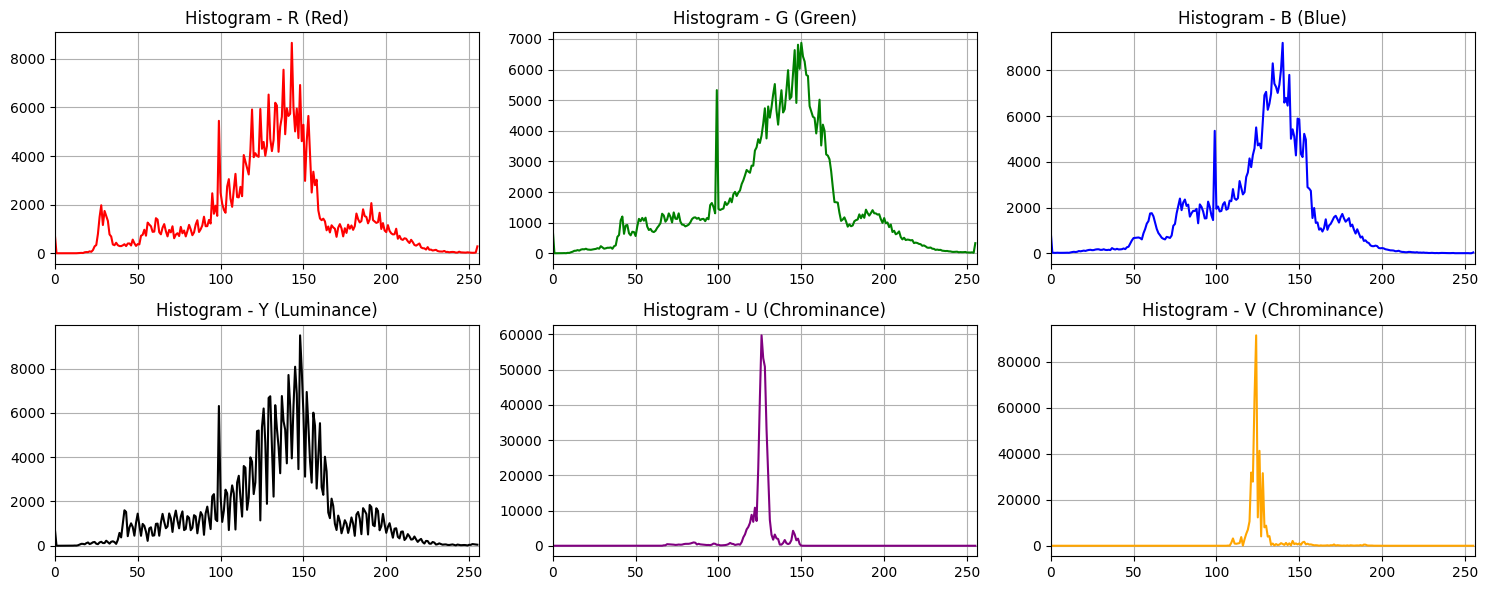

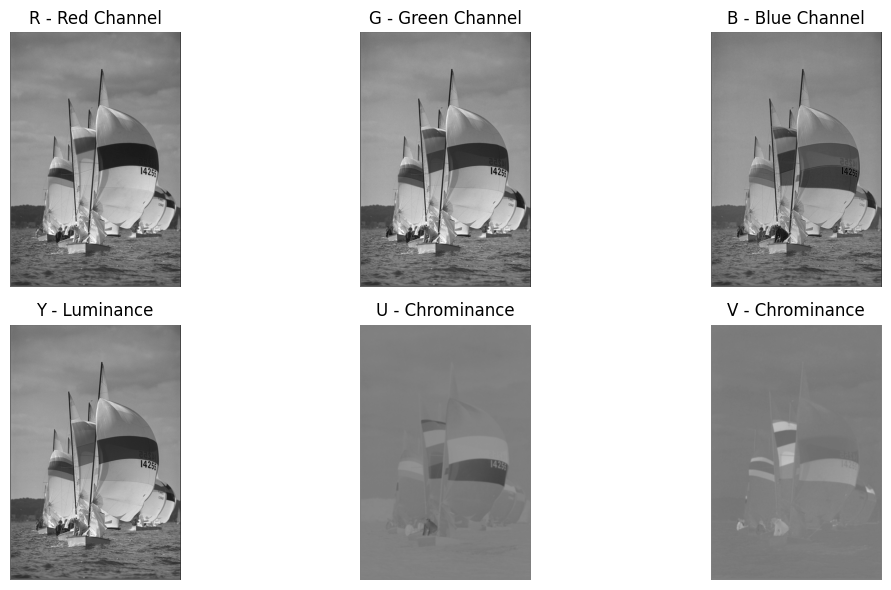

In [112]:
plt.figure(figsize=(15, 6))

# RGB histograms
plt.subplot(2, 3, 1)
plt.plot(hist_R, color='red')
plt.title("Histogram - R (Red)")
plt.xlim([0, 256])
plt.grid()

plt.subplot(2, 3, 2)
plt.plot(hist_G, color='green')
plt.title("Histogram - G (Green)")
plt.xlim([0, 256])
plt.grid()

plt.subplot(2, 3, 3)
plt.plot(hist_B, color='blue')
plt.title("Histogram - B (Blue)")
plt.xlim([0, 256])
plt.grid()

# YUV histograms
plt.subplot(2, 3, 4)
plt.plot(hist_Y, color='black')
plt.title("Histogram - Y (Luminance)")
plt.xlim([0, 256])
plt.grid()

plt.subplot(2, 3, 5)
plt.plot(hist_U, color='purple')
plt.title("Histogram - U (Chrominance)")
plt.xlim([0, 256])
plt.grid()

plt.subplot(2, 3, 6)
plt.plot(hist_V, color='orange')
plt.title("Histogram - V (Chrominance)")
plt.xlim([0, 256])
plt.grid()

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))

# RGB
plt.subplot(2, 3, 1)
plt.imshow(image_R, cmap='gray', vmin=0, vmax=255)
plt.title("R - Red Channel")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(image_G, cmap='gray', vmin=0, vmax=255)
plt.title("G - Green Channel")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(image_B, cmap='gray', vmin=0, vmax=255)
plt.title("B - Blue Channel")
plt.axis('off')

# YUV
plt.subplot(2, 3, 4)
plt.imshow(image_Y, cmap='gray', vmin=0, vmax=255)
plt.title("Y - Luminance")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(image_U, cmap='gray', vmin=0, vmax=255)
plt.title("U - Chrominance")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(image_V, cmap='gray', vmin=0, vmax=255)
plt.title("V - Chrominance")
plt.axis('off')

plt.tight_layout()
plt.show()

### Zad. 3 Zależność zniekształcenia D od przepływności R(bitrate)
D = f(R) – tzw. krzywa R-D – dla kodera JPEG.

In [113]:
def calc_mse_psnr(img1, img2):
    imax = 255.**2
    mse = ((img1.astype(np.float64)-img2)**2).sum()/img1.size
    psnr = 10.0*np.log10(imax/mse)
    return (mse, psnr)

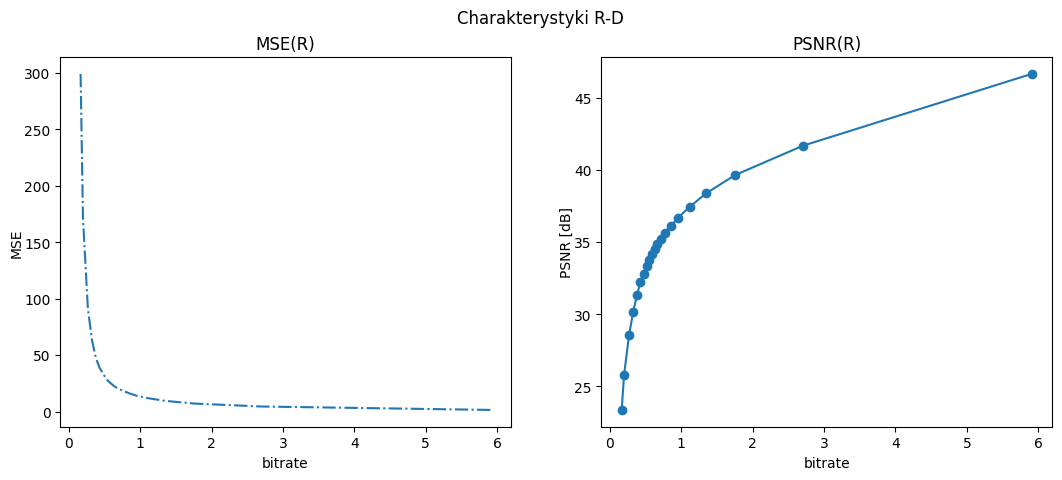

In [118]:
os.makedirs("out_images", exist_ok=True)

image = cv2.imread("images/sailboats_col.png", cv2.IMREAD_UNCHANGED)
xx = [] ### axis X -> bitrate
ym = [] ### axis Y for MSE
yp = [] ### axis Y for PSNR

qualities = range(0, 101, 5)

for quality in qualities:
    out_file_name = f"out_images/out_image_q{quality:03d}.jpg"
    cv2.imwrite(out_file_name, image, (cv2.IMWRITE_JPEG_QUALITY, quality))
    image_compressed = cv2.imread(out_file_name, cv2.IMREAD_UNCHANGED)
    bitrate = 8*os.stat(out_file_name).st_size/(image.shape[0]*image.shape[1])
    mse, psnr = calc_mse_psnr(image, image_compressed)
    xx.append(bitrate)
    ym.append(mse)
    yp.append(psnr)

# Plot the results
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth()*2)
plt.suptitle("Charakterystyki R-D")
plt.subplot(1, 2, 1)
plt.plot(xx, ym, "-.")
plt.title("MSE(R)")
plt.xlabel("bitrate")
plt.ylabel("MSE", labelpad=0)
plt.subplot(1, 2, 2)
plt.plot(xx, yp, "-o")
plt.title("PSNR(R)")
plt.xlabel("bitrate")
plt.ylabel("PSNR [dB]", labelpad=0)
plt.show()

In [117]:
# Calculate bitrate for PNG images
bitrate = 8 * os.stat("images/sailboats_mono.png").st_size / (image_mono.shape[0] * image_mono.shape[1])
print(f"bitrate - png_mono: {bitrate:.4f}")

bitrate = 8 * os.stat("images/sailboats_col.png").st_size / (image_color.shape[0] * image_color.shape[1])
print(f"bitrate - png_color: {bitrate:.4f}")

for quality in qualities:
    image_jpg = cv2.imread(f"out_images/out_image_q{quality:03d}.jpg", cv2.IMREAD_UNCHANGED)
    bitrate = 8 * os.stat(f"out_images/out_image_q{quality:03d}.jpg").st_size / (image_jpg.shape[0] * image_jpg.shape[1])
    print(f"bitrate - png_color_q{quality:03d}: {bitrate:.4f}")


bitrate - png_mono: 4.6111
bitrate - png_color: 11.8750
bitrate - png_color_q010: 0.2669
bitrate - png_color_q015: 0.3262
bitrate - png_color_q020: 0.3787
bitrate - png_color_q025: 0.4277
bitrate - png_color_q030: 0.4718
bitrate - png_color_q035: 0.5137
bitrate - png_color_q040: 0.5490
bitrate - png_color_q045: 0.5884
bitrate - png_color_q050: 0.6254
bitrate - png_color_q055: 0.6626
bitrate - png_color_q060: 0.7114
bitrate - png_color_q065: 0.7760
bitrate - png_color_q070: 0.8583
bitrate - png_color_q075: 0.9551
bitrate - png_color_q080: 1.1167
bitrate - png_color_q085: 1.3488
bitrate - png_color_q090: 1.7538
bitrate - png_color_q095: 2.7012
